In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime
import os
import sys
import dotenv
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir))) # Add parent directory to path

import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    SHConfig
)

from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
from PIL import Image
import io

from modules.utils import plot_image

import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(name)s %(threadName)s : %(message)s')


Configuration

In [3]:
dotenv.load_dotenv()

CLIENT_ID = os.getenv("clientID")
CLIENT_SECRET = os.getenv("clientSecret")

if not CLIENT_ID or not CLIENT_SECRET:
    logging.error("Client ID and/or Client Secret not set in environment variables.")
    raise ValueError("Client ID and/or Client Secret not set in environment variables.")

config = SHConfig()
config.instance_id = "test"
config.sh_client_id = CLIENT_ID
config.sh_client_secret = CLIENT_SECRET
config.sh_base_url = 'https://sh.dataspace.copernicus.eu'
config.sh_token_url = 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token'
config.save()

Copernicus Beginners guide

In [4]:
# set up credentials
client = BackendApplicationClient(client_id=CLIENT_ID)
oauth = OAuth2Session(client=client)

# get an authentication token
token = oauth.fetch_token(
    token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
    client_secret=CLIENT_SECRET,
    include_client_id=True
)

In [5]:
bbox = [-87.72171, 17.11848, -87.342682, 17.481674]
start_date = "2020-06-01"
end_date = "2020-08-31"
collection_id = "sentinel-2-l2a"

In [6]:
# evalscript
evalscript = """
//VERSION=3

function setup() {
  return {
    input: ["B02", "B03", "B04"],
    output: { id: 'default',
              bands: 3 }
  };
}

function evaluatePixel(sample) {
  return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02];
}
"""

# request body/payload
json_request = {
    'input': {
        'bounds': {
            'bbox': bbox,
            'properties': {
                'crs': 'http://www.opengis.net/def/crs/OGC/1.3/CRS84'
            }
        },
        'data': [
            {
                'type': 'S2L2A',
                'dataFilter': {
                    'timeRange': {
                        'from': f'{start_date}T00:00:00Z',
                        'to': f'{end_date}T23:59:59Z'
                    },
                    'mosaickingOrder': 'leastCC',
                },
            }
        ]
    },
    'output': {
        'width': 1024,
        'height': 1024,
        'responses': [
            {
                'identifier': 'default',
                'format': {
                    'type': 'image/jpeg',
                }
            }
        ]
    },
    'evalscript': evalscript
}

In [12]:
# Set the request URL and headers
url_request = "https://sh.dataspace.copernicus.eu/api/v1/process"
headers_request = {
    "Authorization": f"Bearer {token['access_token']}"
}

# Send the request
response = oauth.post(url_request, headers=headers_request, json=json_request)

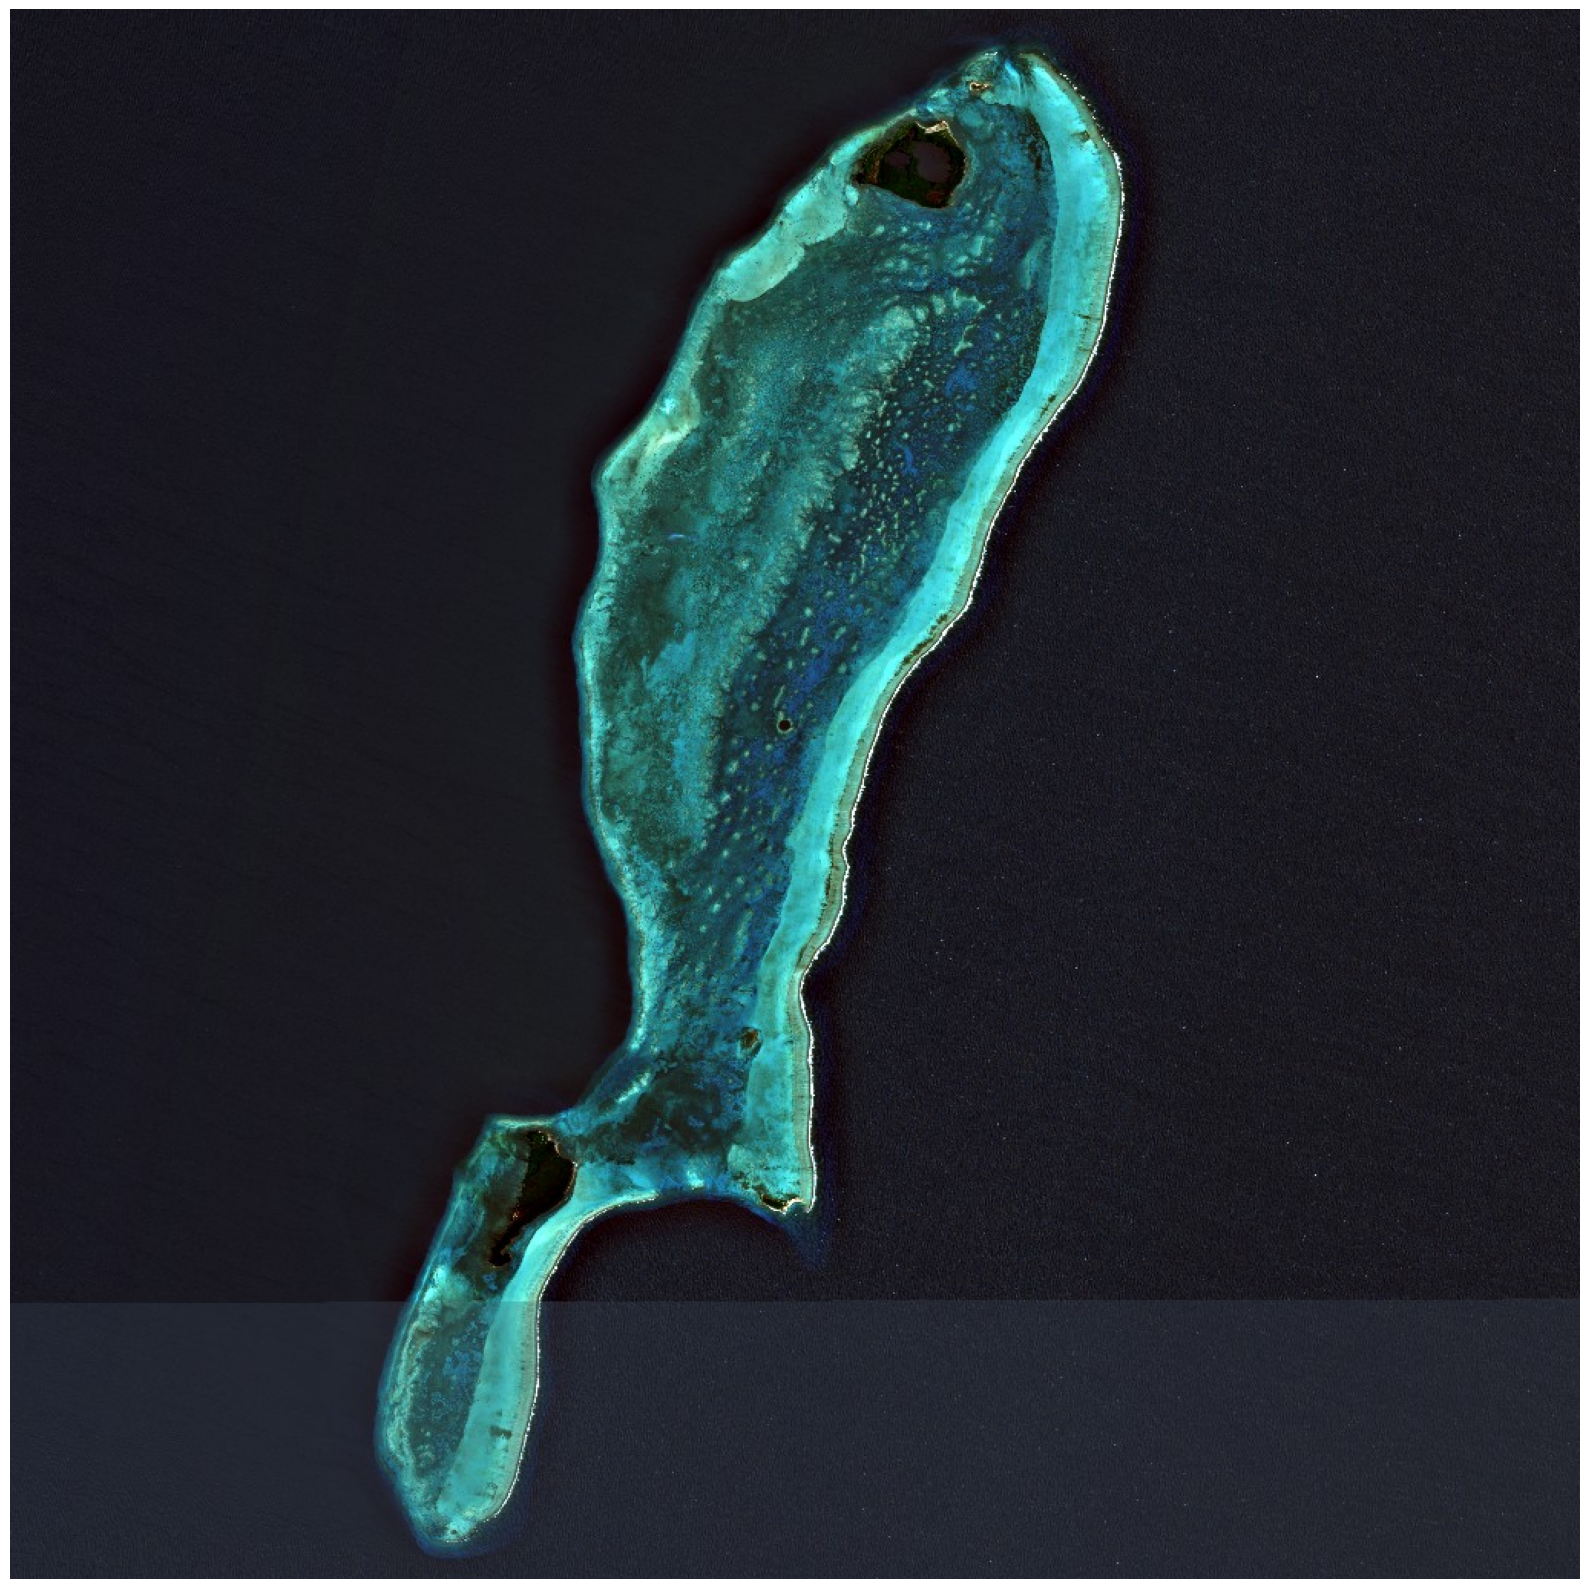

In [13]:
# read the image as numpy array
image_arr = np.array(Image.open(io.BytesIO(response.content)))

# plot the image for visualization
plt.figure(figsize=(16,16))
plt.axis('off')
plt.tight_layout()
plt.imshow(image_arr)

Plotting Betsiboka River in Madagaskar

In [15]:
betsiboka_coords_wgs84 = (46.16, -16.15, 46.51, -15.58)

resolution = 60
betsiboka_bbox = BBox(bbox=betsiboka_coords_wgs84, crs=CRS.WGS84)
betsiboka_size = bbox_to_dimensions(betsiboka_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {betsiboka_size} pixels")

Image shape at 60 m resolution: (631, 1047) pixels


In [16]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            DataCollection.SENTINEL2_L1C.define_from("s2l1c", service_url=config.sh_base_url),
            time_interval=("2020-06-12", "2020-06-13"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config,
)

In [17]:
true_color_imgs = request_true_color.get_data()

Image type: uint8


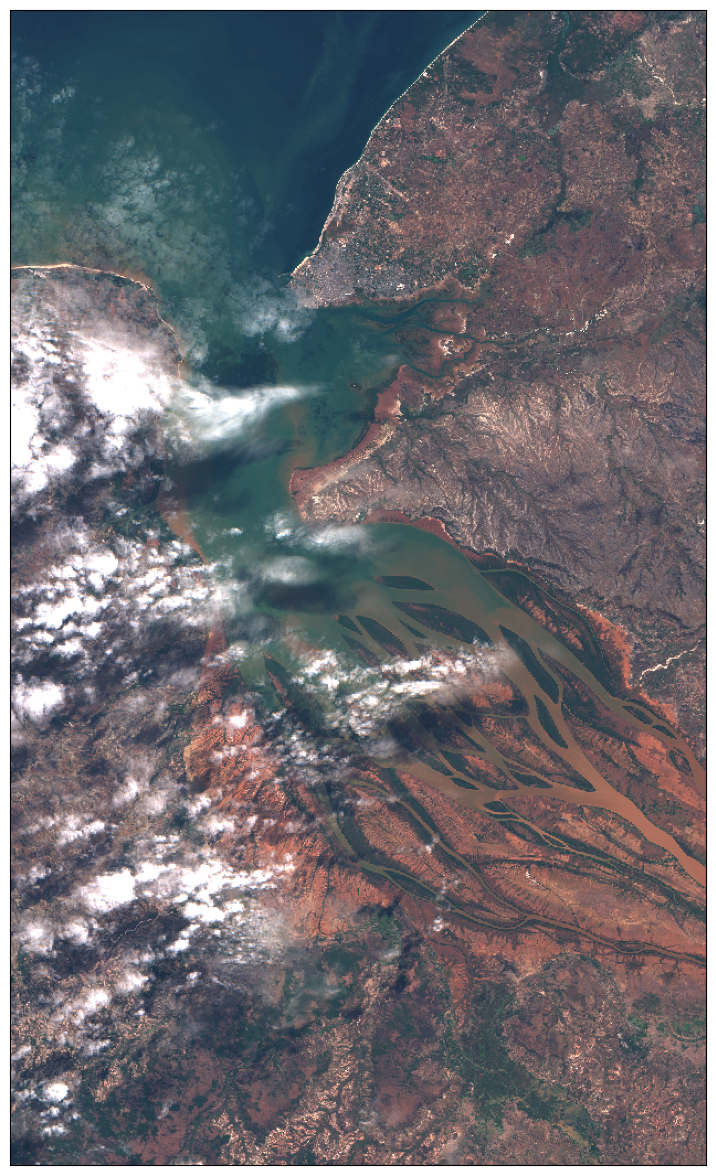

In [19]:
image = true_color_imgs[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=3.5 / 255, clip_range=(0, 1))

Picture of Nordjylland!

Image shape at 60 m resolution: (1590, 1564) pixels
Image type: uint8


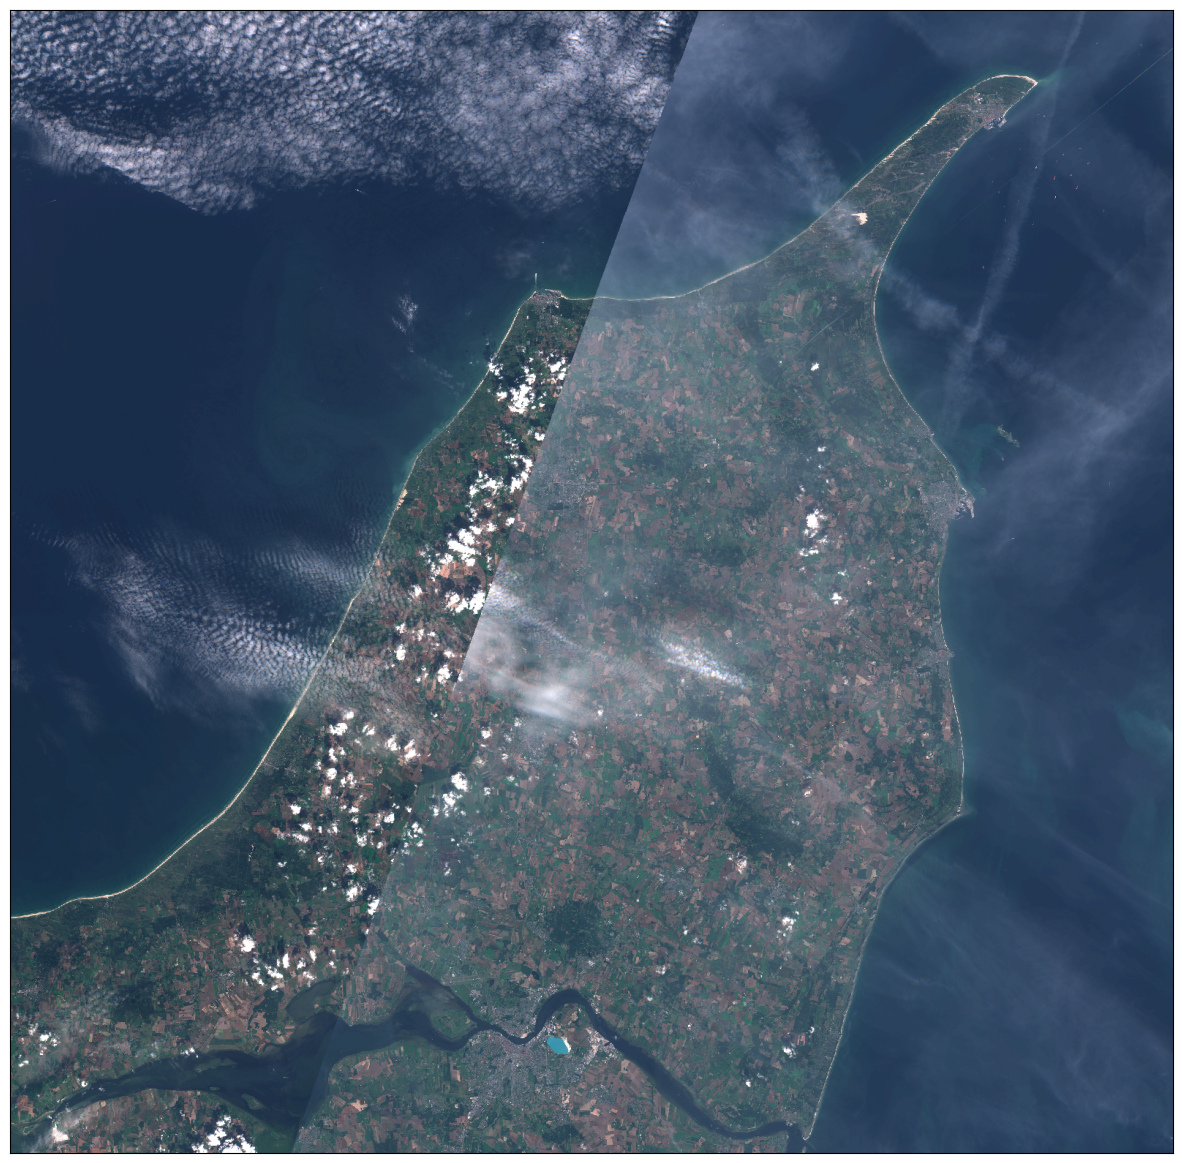

In [34]:
nordjylland_coords_wgs84 = (9.23, 56.97, 10.84, 57.80)  # Coordinates for Nordjylland, Denmark

resolution = 60
nordjylland_bbox = BBox(bbox=nordjylland_coords_wgs84, crs=CRS.WGS84)
nordjylland_size = bbox_to_dimensions(nordjylland_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {nordjylland_size} pixels")

evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            DataCollection.SENTINEL2_L1C.define_from("s2l1c", service_url=config.sh_base_url),
            time_interval=("2024-08-01", "2024-08-02"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=nordjylland_bbox,
    size=nordjylland_size,
    config=config,
)

true_color_imgs = request_true_color.get_data()

image = true_color_imgs[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=3.5 / 255, clip_range=(0, 1))